In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time

# import functions for ODE parameter estimation
from model.diag_Gaussian import *

np.random.seed(123)

/home/jaron/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/jaron/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/tmp/ipykernel_12431/351698786.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
Matplotlib created a temporary config/cac

## Parameter estimation of ODE models: 

$$
\frac{d \mathbf{x}}{d t} = f(\mathbf{x}, t, \theta) 
$$
where $\mathbf{x}$ is a vector of state variables and $\theta$ is a vector of model parameters to be estimated from data 

## Define ODE (x, time, parameters)

In [2]:
# ode 
def system(x, t, params): 

    # unpack parameters
    mu_max, pref, alpha, K_inv, delta = params
    
    # unpack variables
    od, pH = x 
    
    # growth rate modified by pH preference 
    # mu = mu_max * jnp.exp(-alpha * (pH - pref)**2)
           
    # coupled ODE for cells and environmental pH
    dod = od * (mu_max - K_inv * od) * (jnp.exp(-alpha * (pH - pref)**2) - delta)
    dpH = 0. # gamma * od
    
    return jnp.array([dod, dpH])  

# define transform function to constrain parameter values
def transform(params):

    # unpack parameters
    mu_max, pref, alpha, K_inv, delta = params
    
    # take exp of strictly positive parameters
    mu_max = jnp.exp2(mu_max)
    pref = 7.*jnp.exp2(pref)
    alpha = jnp.exp2(alpha)/100.
    K_inv = jnp.exp2(K_inv)/10.
    delta = jnp.exp2(delta)/10.
    
    return jnp.array([mu_max, pref, alpha, K_inv, delta])

# define prior mean of transformed variables 
prior_mean = jnp.array([1., 7., 0., 1., 0.])

# prior precision 
alpha = 10. # jnp.array([10, 1, 100, 1, 1])

## Import data as a Pandas dataframe 

The dataframe must have a "Treatments" column that provides a unique identifier for each condition. The second column specifies the time point that observations were made. The following columns include the state variables.

In [3]:
# import data
df = pd.read_csv("Data/arc_allmono.csv").rename(columns={"Experiments":"Treatments"})
df

,Treatments,Time,pH,AC_OD,BA_OD,BC_OD,BL_OD,BT_OD,BV_OD,CC_OD,DF_OD,wt_OD,delarc_OD,parc-_OD,parc+_OD
0,AC_pH4_0,0,5.003232,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,AC_pH4_0,3,5.014134,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,AC_pH4_0,6,5.016297,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,AC_pH4_0,9,5.043927,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,AC_pH4_0,12,5.011965,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,parc+_pH9_2,0,8.132268,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010000
1220,parc+_pH9_2,3,8.040755,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.183878
1221,parc+_pH9_2,6,7.873923,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.026189
1222,parc+_pH9_2,9,7.745788,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.903504


In [4]:
df_AC = pd.concat([df_exp[['Treatments', 'Time', 'pH', 'AC_OD']] for exp_name, df_exp in df.groupby("Treatments") if "AC" in exp_name])
df_AC

,Treatments,Time,pH,AC_OD
0,AC_pH4_0,0,5.003232,0.010000
1,AC_pH4_0,3,5.014134,0.010000
2,AC_pH4_0,6,5.016297,0.010000
3,AC_pH4_0,9,5.043927,0.010000
4,AC_pH4_0,12,5.011965,0.010000
...,...,...,...,...
103,AC_pH9_2,3,7.583511,0.046036
104,AC_pH9_2,6,7.604837,0.449068
105,AC_pH9_2,9,7.339334,3.110981
106,AC_pH9_2,12,7.093441,5.010713


## Specify system state variables 

In [5]:
# names of species
species = ['AC_OD', 'pH']

# global parameters used in ODE
n_s = len(species)

## Instantiate the model with the ODE function, training dataframe, system variables, and initial parameter guess

In [6]:
# instantiate gLV fit 
ode_model = ODE(system = system, 
            transform = transform,
            dataframe = df_AC, 
            sys_vars = species, 
            prior_mean = prior_mean, 
            alpha=alpha, beta=10.)

## Fit the parameter posterior

In [7]:
# fit to data 
t0 = time.time()
ode_model.fit_posterior_EM(n_sample_sgd=1, 
                           n_sample_hypers=50, 
                           n_sample_evidence=100, 
                           patience=3)

print("Elapsed time {:.2f}s".format(time.time()-t0))

Computing model evidence...


100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 70.48it/s]


Log evidence: -1215.169
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 104.38it/s]


Updating posterior...
Epoch 1, NEG ELBO: 126.413
Epoch 2, NEG ELBO: 90.564
Epoch 3, NEG ELBO: 84.802
Epoch 4, NEG ELBO: 79.685
Epoch 5, NEG ELBO: 77.270
Epoch 6, NEG ELBO: 74.030
Epoch 7, NEG ELBO: 71.083
Epoch 8, NEG ELBO: 68.704
Epoch 9, NEG ELBO: 67.398
Epoch 10, NEG ELBO: 70.268
set lr to 1.000e-02
Epoch 11, NEG ELBO: 69.986, Slope: -0.025
set lr to 1.000e-02
Epoch 12, NEG ELBO: 67.534, Slope: -0.020
set lr to 1.000e-02
Epoch 13, NEG ELBO: 66.804, Slope: -0.016
set lr to 1.000e-02
Epoch 14, NEG ELBO: 66.749, Slope: -0.012
Epoch 15, NEG ELBO: 65.923, Slope: -0.009
Epoch 16, NEG ELBO: 66.972, Slope: -0.006
Epoch 17, NEG ELBO: 65.072, Slope: -0.006
Epoch 18, NEG ELBO: 66.279, Slope: -0.006
Epoch 19, NEG ELBO: 65.349, Slope: -0.007
Epoch 20, NEG ELBO: 64.465, Slope: -0.006
Epoch 21, NEG ELBO: 67.559, Slope: -0.002
Epoch 22, NEG ELBO: 67.160, Slope: -0.000
Epoch 23, NEG ELBO: 64.315, Slope: -0.001
Epoch 24, NEG ELBO: 65.648, Slope: -0.001
Epoch 25, NEG ELBO: 65.630, Slope: -0.001
decrea

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 107.13it/s]


Log evidence: -256.132
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 131.20it/s]


Updating posterior...
Epoch 1, NEG ELBO: 97.770
Epoch 2, NEG ELBO: 108.900
Epoch 3, NEG ELBO: 104.022
Epoch 4, NEG ELBO: 106.577
Epoch 5, NEG ELBO: 105.048
Epoch 6, NEG ELBO: 97.043
Epoch 7, NEG ELBO: 103.478
Epoch 8, NEG ELBO: 101.993
Epoch 9, NEG ELBO: 101.439
Epoch 10, NEG ELBO: 100.489
Epoch 11, NEG ELBO: 97.329, Slope: -0.009
Epoch 12, NEG ELBO: 100.986, Slope: -0.006
Epoch 13, NEG ELBO: 106.353, Slope: -0.002
decrease lr to 9.000e-03
Epoch 14, NEG ELBO: 109.854, Slope: 0.004
decrease lr to 8.100e-03
Epoch 15, NEG ELBO: 110.025, Slope: 0.010
decrease lr to 7.290e-03
Epoch 16, NEG ELBO: 97.237, Slope: 0.003
decrease lr to 6.561e-03
Epoch 17, NEG ELBO: 96.240, Slope: 0.001
Epoch 18, NEG ELBO: 101.084, Slope: -0.000
Epoch 19, NEG ELBO: 97.683, Slope: -0.003
decrease lr to 5.905e-03
Epoch 20, NEG ELBO: 112.699, Slope: 0.002
Epoch 21, NEG ELBO: 98.816, Slope: -0.003
Epoch 22, NEG ELBO: 96.494, Slope: -0.008
Epoch 23, NEG ELBO: 105.041, Slope: -0.005
Epoch 24, NEG ELBO: 97.676, Slope: -

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 135.15it/s]


Log evidence: -198.182
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 133.43it/s]


Updating posterior...
Epoch 1, NEG ELBO: 108.527
Epoch 2, NEG ELBO: 111.610
Epoch 3, NEG ELBO: 101.160
Epoch 4, NEG ELBO: 102.089
Epoch 5, NEG ELBO: 104.921
Epoch 6, NEG ELBO: 102.309
Epoch 7, NEG ELBO: 102.554
Epoch 8, NEG ELBO: 105.692
Epoch 9, NEG ELBO: 100.517
Epoch 10, NEG ELBO: 110.634
Epoch 11, NEG ELBO: 94.189, Slope: -0.005
Epoch 12, NEG ELBO: 94.328, Slope: -0.005
Epoch 13, NEG ELBO: 107.740, Slope: -0.002
Epoch 14, NEG ELBO: 106.523, Slope: -0.001
Epoch 15, NEG ELBO: 90.331, Slope: -0.006
Epoch 16, NEG ELBO: 94.010, Slope: -0.009
Epoch 17, NEG ELBO: 102.002, Slope: -0.007
Epoch 18, NEG ELBO: 88.869, Slope: -0.010
set lr to 1.000e-02
Epoch 19, NEG ELBO: 92.591, Slope: -0.012
Epoch 20, NEG ELBO: 92.385, Slope: -0.007
decrease lr to 9.000e-03
Epoch 21, NEG ELBO: 117.838, Slope: 0.002
Epoch 22, NEG ELBO: 99.453, Slope: -0.000
decrease lr to 8.100e-03
Epoch 23, NEG ELBO: 90.767, Slope: 0.001
decrease lr to 7.290e-03
Epoch 24, NEG ELBO: 92.865, Slope: 0.004
Epoch 25, NEG ELBO: 90.

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 127.99it/s]


Log evidence: -197.627
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 141.65it/s]


Updating posterior...
Epoch 1, NEG ELBO: 89.335
Epoch 2, NEG ELBO: 164.386
Epoch 3, NEG ELBO: 106.978
Epoch 4, NEG ELBO: 89.205
Epoch 5, NEG ELBO: 92.058
Epoch 6, NEG ELBO: 100.944
Epoch 7, NEG ELBO: 97.800
Epoch 8, NEG ELBO: 86.309
Epoch 9, NEG ELBO: 89.089
Epoch 10, NEG ELBO: 113.259
set lr to 1.000e-02
Epoch 11, NEG ELBO: 87.407, Slope: -0.025
Epoch 12, NEG ELBO: 99.437, Slope: -0.001
decrease lr to 9.000e-03
Epoch 13, NEG ELBO: 97.570, Slope: 0.006
decrease lr to 8.100e-03
Epoch 14, NEG ELBO: 91.102, Slope: 0.000
Epoch 15, NEG ELBO: 90.093, Slope: -0.004
Epoch 16, NEG ELBO: 90.844, Slope: -0.003
Epoch 17, NEG ELBO: 82.588, Slope: -0.007
decrease lr to 7.290e-03
Epoch 18, NEG ELBO: 117.150, Slope: 0.001
decrease lr to 6.561e-03
Epoch 19, NEG ELBO: 163.057, Slope: 0.020
decrease lr to 5.905e-03
Epoch 20, NEG ELBO: 86.489, Slope: 0.019
decrease lr to 5.314e-03
Epoch 21, NEG ELBO: 88.087, Slope: 0.009
decrease lr to 4.783e-03
Epoch 22, NEG ELBO: 93.270, Slope: 0.006
Epoch 23, NEG ELBO:

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 119.30it/s]


Log evidence: -260.126
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 136.81it/s]


Updating posterior...
Epoch 1, NEG ELBO: 107.341
Epoch 2, NEG ELBO: 106.890
Epoch 3, NEG ELBO: 115.915
Epoch 4, NEG ELBO: 114.628
Epoch 5, NEG ELBO: 137.730
Epoch 6, NEG ELBO: 160.684
Epoch 7, NEG ELBO: 125.472
Epoch 8, NEG ELBO: 125.948
Epoch 9, NEG ELBO: 162.613
Epoch 10, NEG ELBO: 113.520
decrease lr to 9.000e-03
Epoch 11, NEG ELBO: 111.434, Slope: 0.007
Epoch 12, NEG ELBO: 107.331, Slope: -0.008
Epoch 13, NEG ELBO: 147.868, Slope: -0.006
set lr to 9.900e-03
Epoch 14, NEG ELBO: 120.235, Slope: -0.016
set lr to 1.000e-02
Epoch 15, NEG ELBO: 105.440, Slope: -0.022
set lr to 1.000e-02
Epoch 16, NEG ELBO: 109.177, Slope: -0.015
set lr to 1.000e-02
Epoch 17, NEG ELBO: 125.790, Slope: -0.013
set lr to 1.000e-02
Epoch 18, NEG ELBO: 100.444, Slope: -0.019
Epoch 19, NEG ELBO: 105.538, Slope: -0.008
Epoch 20, NEG ELBO: 116.930, Slope: -0.007
decrease lr to 9.000e-03
Epoch 21, NEG ELBO: 318.616, Slope: 0.031
decrease lr to 8.100e-03
Epoch 22, NEG ELBO: 106.697, Slope: 0.020
decrease lr to 7.29

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 119.09it/s]


Log evidence: -554.661
Updating hyperparameters...


100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 136.00it/s]


Updating posterior...
Epoch 1, NEG ELBO: 137.631
Epoch 2, NEG ELBO: 125.941
Epoch 3, NEG ELBO: 159.432
Epoch 4, NEG ELBO: 138.582
Epoch 5, NEG ELBO: 219.346
Epoch 6, NEG ELBO: 152.341
Epoch 7, NEG ELBO: 129.443
Epoch 8, NEG ELBO: 124.710
Epoch 9, NEG ELBO: 117.221
Epoch 10, NEG ELBO: 193.187
Epoch 11, NEG ELBO: 117.389, Slope: -0.007
decrease lr to 9.000e-03
Epoch 12, NEG ELBO: 289.231, Slope: 0.016
decrease lr to 8.100e-03
Epoch 13, NEG ELBO: 134.192, Slope: 0.010
Epoch 14, NEG ELBO: 114.268, Slope: -0.005
decrease lr to 7.290e-03
Epoch 15, NEG ELBO: 116.623, Slope: 0.001
Epoch 16, NEG ELBO: 118.302, Slope: -0.004
set lr to 8.019e-03
Epoch 17, NEG ELBO: 123.059, Slope: -0.012
set lr to 8.821e-03
Epoch 18, NEG ELBO: 112.505, Slope: -0.022
decrease lr to 7.939e-03
Epoch 19, NEG ELBO: 475.097, Slope: 0.021
decrease lr to 7.145e-03
Epoch 20, NEG ELBO: 130.051, Slope: 0.017
decrease lr to 6.430e-03
Epoch 21, NEG ELBO: 116.781, Slope: 0.003
decrease lr to 5.787e-03
Epoch 22, NEG ELBO: 114.0

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 120.00it/s]

Log evidence: -249.418
Elapsed time 24.16s


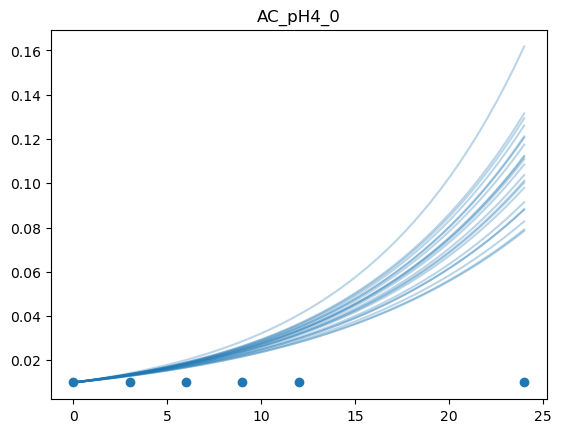

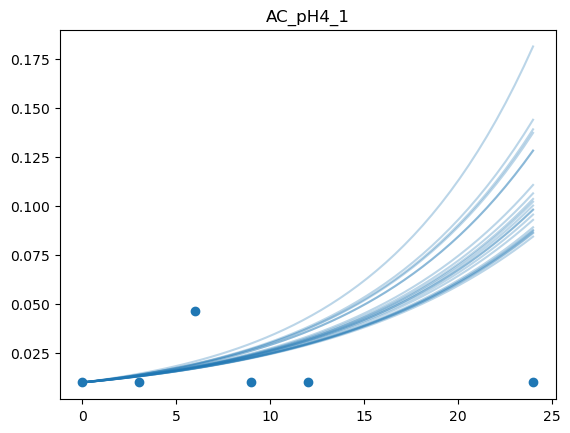

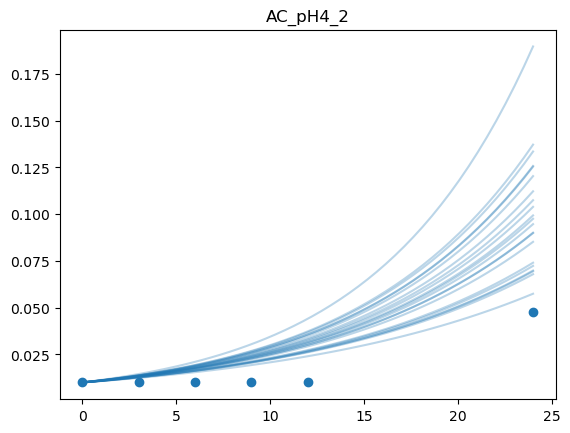

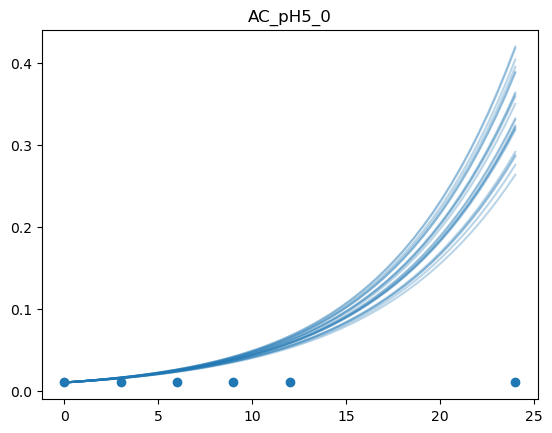

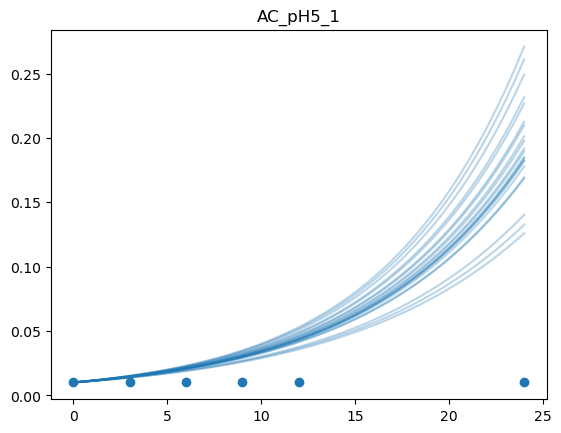

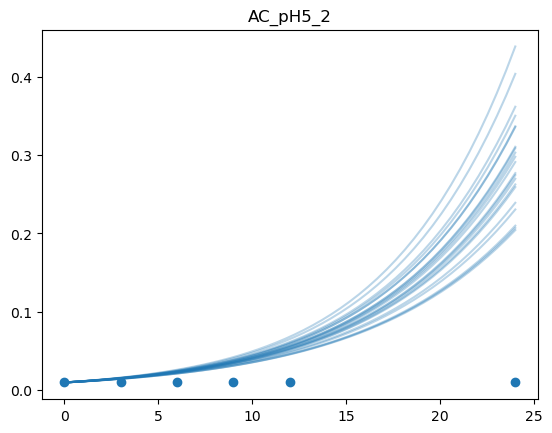

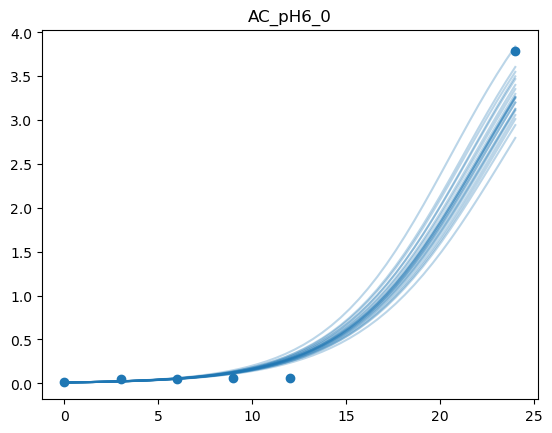

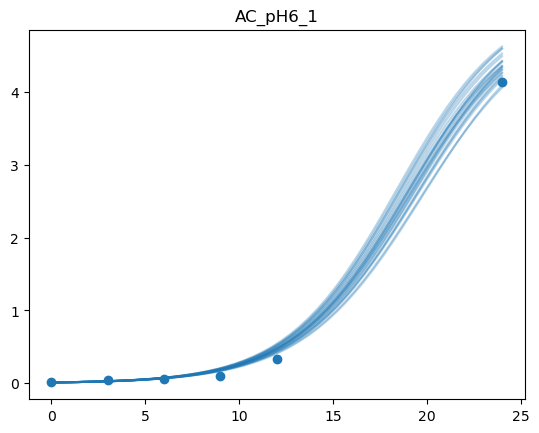

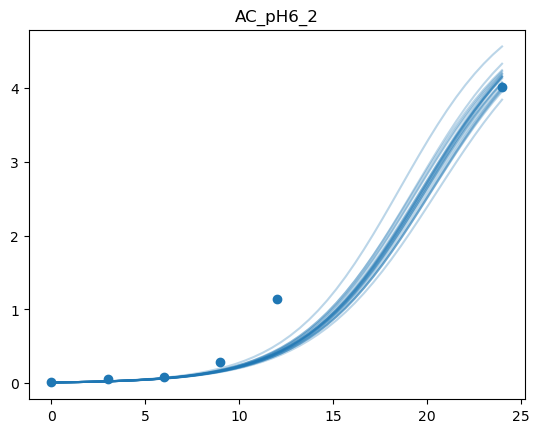

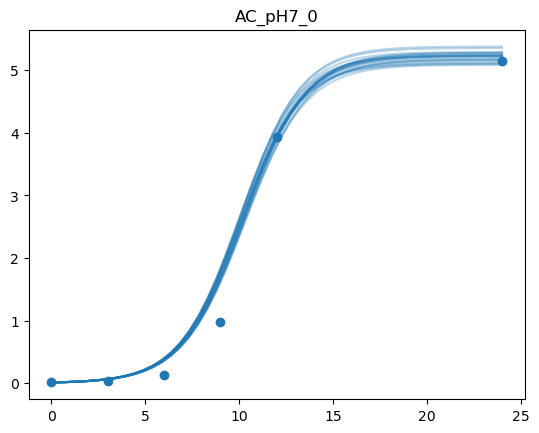

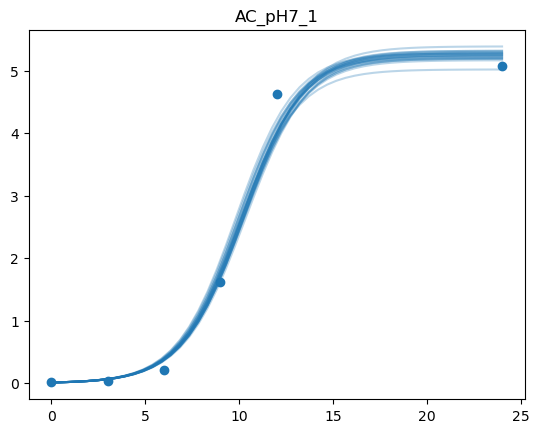

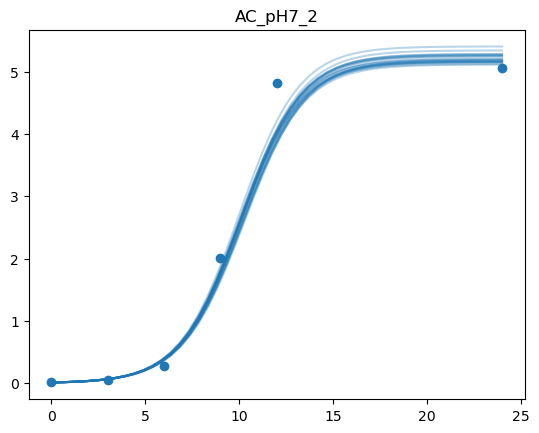

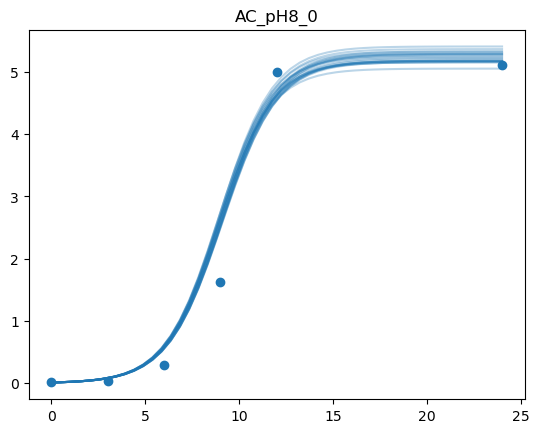

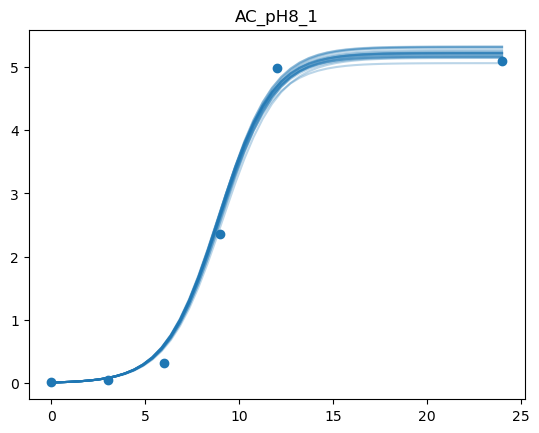

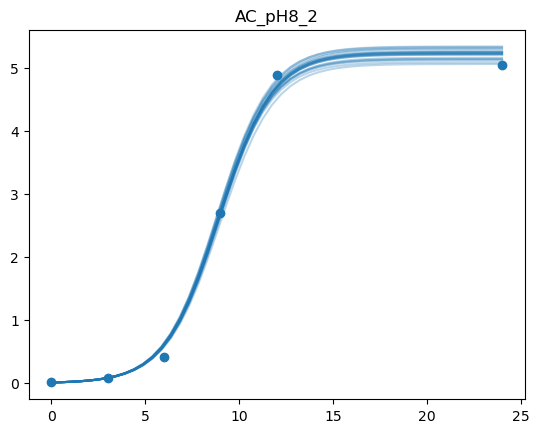

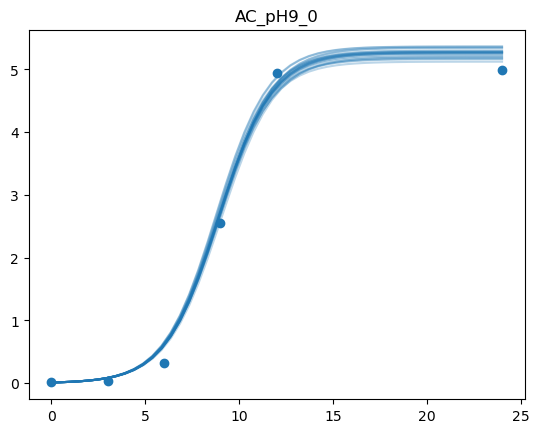

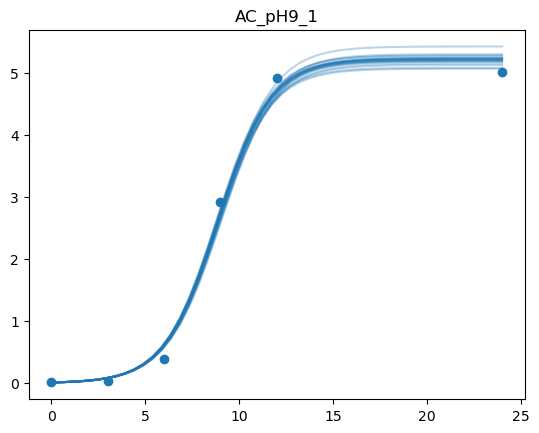

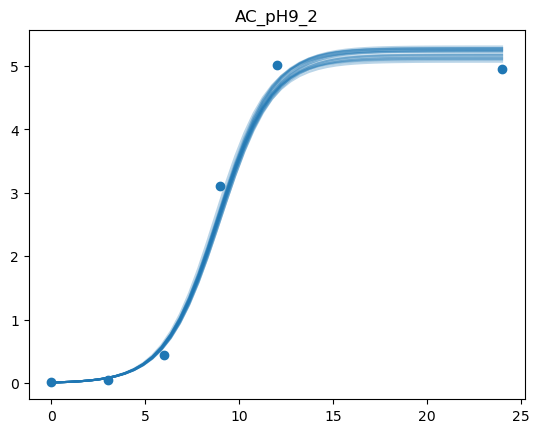

In [8]:
# random conditions to plot
# plt_conditions = np.random.choice(np.unique(df.Treatments.values), 5, replace=False)

# for exp_name in plt_conditions:
for exp_name, exp_df in df_AC.groupby("Treatments"):
    # pull dataframe
    # exp_df = df.iloc[df.Treatments.values==exp_name].copy()
    
    # predict values
    x0 = exp_df[species].values[0]
    t_eval = np.linspace(0., max(exp_df.Time.values))
    y_preds = ode_model.predict_sample(x0, t_eval)
    
    # plot 
    for i, s in enumerate(species[:1]):
        plt.scatter(exp_df.Time.values, exp_df[s].values)
        for y_pred in y_preds:
            plt.plot(t_eval, y_pred[:, i], alpha=.3, c=f'C{i}')
    
    plt.title(exp_name)
    plt.show()

## Save parameter values

In [9]:
# Define names of parameters 
df_params = ode_model.param_df()
df_params

,mean,stdv
0,1.028433,0.005432
1,7.198111,0.013728
2,0.187852,0.003343
3,0.196744,0.002580
4,0.312160,0.003925
